# Radar cross section detection calculator

This tutorial demonstrates how to determine a radar's ability to track differently sized targets with varying radar cross sections using Python and PySTK. It is inspired by [this](https://help.agi.com/stk/Content/training/StartRadar.htm) tutorial.

## What is radar cross section?

One important property of a potential radar target is its radar cross section (RCS), which measures how easily the object can be detected by a radar, with a higher RCS corresponding to a more easily detected target. How easily an object can be detected has to do with its echo, which is a function of its size, shape, and orientation. RCS is the projected area of a metal sphere that would return the same echo signal as the target if it were substituted for the target. Through STK, it is possible to either specify the RCS of all targets at the scenario level, or to specify the RCS individually for each target. It is also possible to select different RCS computation methods, including directly using a constant value, using output files from [Ansys HFSS](https://www.ansys.com/products/electronics/ansys-hfss), and using aspect dependent RCS files. Finally, STK supports the use of Swerling cases, which account for RCS fluctuations considering a range of fluctuation values and possible correlations between radar scans.

## Problem statement

A radar site which surveils aircraft flying over it is located at latitude $35.75174^\circ$ and longitude $139.35621^\circ$. The site's antenna is located $50$ ft above the ground. The radar site has a servo system for antenna positioning, modeled by a sensor with a simple conic field of view with a $2^\circ$ half angle. The sensor locks onto aircraft. The sensor can track aircraft with an elevation angle from $0^\circ$ to $30^\circ$, and a range of up to $150$ km. Anything higher than $30^\circ$ is the cone of silence in which the radar cannot track the aircraft. The sensor has a monostatic aircraft surveillance radar on it with a search/track mode. The radar has a waveform with a fixed pulse repetition frequency of $1000$ Hz and a pulse width of $1$ microsecond. The radar's antenna is modeled by the cosine squared aperture rectangular antenna pattern, with an antenna transmit frequency between $2.7$ and $2.9$ GHz. The antenna also has an X dimension beamwidth of $5^\circ$, a Y dimension beamwidth of $1.4^\circ$, a design frequency of $2.8$ GHz, a main-lobe gain of $34$ dB, and an efficiency of $55$%. The radar's transmitter has a frequency range of $2.7-2.9$ GHz, a peak power of $20$ kW, and uses linear polarization. The radar's receiver uses linear polarization, and computes system noise temperature taking into account Sun and cosmic background noise.

Using a test aircraft, determine if the aircraft surveillance radar can see a large aircraft (RCS: $19$ dBsm), a medium aircraft (RCS: $10$ dBsm), a small aircraft (RCS: $0$ dBsm), and a bird (RCS: $-20$ dBsm).

## Launch a new STK instance

Start by launching a new STK instance. In this example, STKEngine is used.

In [1]:
from ansys.stk.core.stkengine import STKEngine


stk = STKEngine.start_application(no_graphics=False)
print(f"Using {stk.version}")

Using STK Engine v12.10.0


## Create a new scenario

Create an STK scenario using the STK Root object:

In [2]:
root = stk.new_object_root()
root.new_scenario("IntroductionToRadar")

Once the scenario is created, it is possible to show a 3D graphics window by running:

RFBOutputContext()

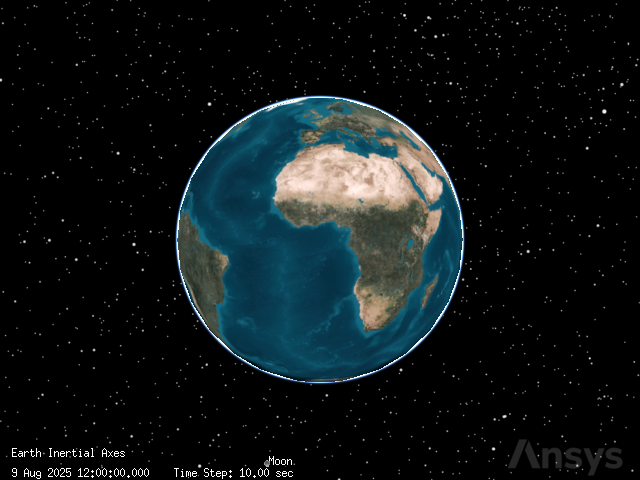

In [3]:
from ansys.stk.core.stkengine.experimental.jupyterwidgets import GlobeWidget


globe_widget = GlobeWidget(root, 640, 480)
globe_widget.show()

Show a 2D graphics window by running:

RFBOutputContext()

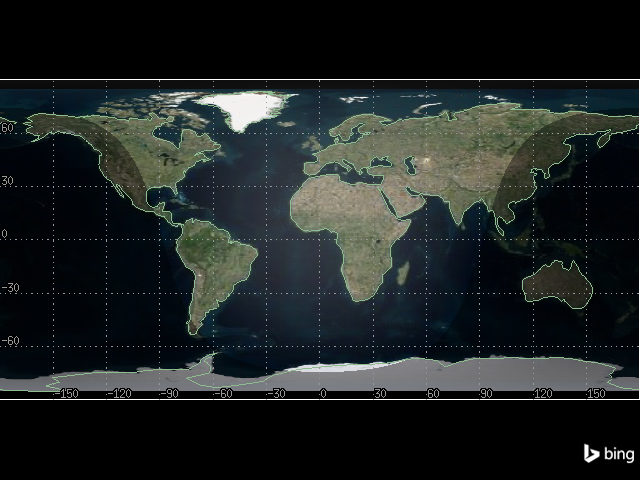

In [4]:
from ansys.stk.core.stkengine.experimental.jupyterwidgets import MapWidget


map_widget = MapWidget(root, 640, 480)
map_widget.show()

## Set the scenario time period

Using the newly created scenario, set the start and stop times. Rewind the scenario so that the graphics match the start and stop times of the scenario:

In [5]:
scenario = root.current_scenario
scenario.set_time_period("5 May 2024 03:00:00.000", "5 May 2024 03:30:00.000")
root.rewind()

## Create the target aircraft

A test aircraft is used to analyze the airfield surveillance radar. Insert the aircraft:

In [6]:
from ansys.stk.core.stkobjects import STKObjectType


aircraft = root.current_scenario.children.new(STKObjectType.AIRCRAFT, "TargetAircraft")

The aircraft's route is designated by a great arc propagator, which uses waypoints to calculate how the aircraft flies. The aircraft flies between two waypoints. The first is located at latitude $37^\circ$ and longitude $139.7^\circ$, and the second is located at latitude $34^\circ$ and longitude $139.1^\circ$. The aircraft flies at an altitude of $25000$ ft ($7.62$ km) and a speed of $330$ nm/hr at both waypoints.

Insert the first waypoint:

In [7]:
waypoint1 = aircraft.route.waypoints.add()
waypoint1.latitude = 37
waypoint1.longitude = 139.7
waypoint1.altitude = 7.62
waypoint1.speed = 330

Insert the second waypoint:

In [8]:
waypoint2 = aircraft.route.waypoints.add()
waypoint2.latitude = 34
waypoint2.longitude = 139.1
waypoint2.altitude = 7.62
waypoint2.speed = 330

Then, propagate the aircraft's route:

In [9]:
aircraft.route.propagate()

It is now possible to view the aircraft's route in the 2D graphics window:

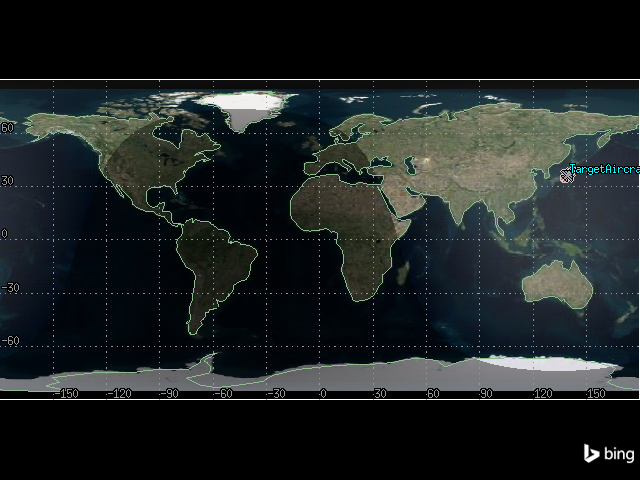

In [10]:
map_widget.camera.position = [-12290, 32850, 0.0]
map_widget.show()

## Specify the radar cross section

Before setting up and constraining a radar system, STK allows the specification of a potential radar target's radar cross section. Use the RCS of a popular four-engined turboprop transport aircraft.

First, set the radar cross section's `inherit` property to `False`. When the `inherit` property is set to `True`, the RCS is inherited from the scenario. In this case, set the property to `False` to specify the RCS for only the aircraft:

In [11]:
aircraft.radar_cross_section.inherit = False

Get the model's first frequency band:

In [12]:
band1 = aircraft.radar_cross_section.model_component_linking.component.frequency_bands[
    0
]

Configure the band to use a constant frequency:

In [13]:
band1.set_compute_strategy("Constant Value")

Set the constant frequency to $19$ dBsm:

In [14]:
band1.compute_strategy.constant_value = 19

Next, configure the radar 3D graphics. Enable the visualization of RCS volume for the aircraft:

In [15]:
aircraft.graphics_3d.radar_cross_section.volume_graphics.show = True

It is now possible to see the aircraft's constant RCS in the 3D graphics window:

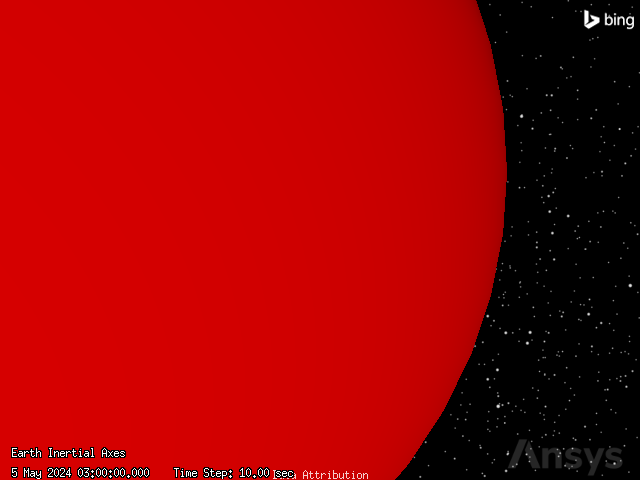

In [16]:
globe_widget.camera.position = [3435.3329, 3789.8112, 3815.5677]
globe_widget.show()

## Insert the radar site

The radar site is modeled by a place object. Insert the site:

In [17]:
from ansys.stk.core.stkobjects import Place


radar_site = Place(root.current_scenario.children.new(STKObjectType.PLACE, "RadarSite"))

The site is located at latitude $35.75174^\circ$ and longitude $139.35621^\circ$. The site's antenna is located $50$ ft above the ground. Assign the site's position:

In [18]:
radar_site.use_terrain = False
radar_site.position.assign_geodetic(35.75174, 139.35621, 0.01524)

## Insert the antenna servo system

Insert a sensor to simulate a servo system for antenna positioning. In STK, it is possible to create a spinning sensor to simulate a spinning radar antenna normally seen at an airfield. However, in this case, the sensor locks onto the aircraft and is constrained to point in a limited area. This simulates the actual field of view of the airfield surveillance radar both horizontally and vertically.

Insert a sensor on the radar site:

In [19]:
antenna_sensor = radar_site.children.new(STKObjectType.SENSOR, "AntennaSensor")

Assign a simple conic field of view with a $2^\circ$ half angle to the sensor:

In [20]:
from ansys.stk.core.stkobjects import SensorPattern


antenna_sensor.common_tasks.set_pattern_simple_conic(2, 1)

The sensor points at the aircraft, so set the sensor's pointing type to targeted:

In [21]:
from ansys.stk.core.stkobjects import SensorPointing


antenna_sensor.set_pointing_type(SensorPointing.TARGETED)

Finally, set the aircraft as the sensor's target:

In [22]:
antenna_sensor.pointing.targets.add(aircraft.path)

## Set range and elevation angle constraints

A typical airport surveillance radar's nominal range is $60$ miles and the elevation angle of the beam can track from $0^\circ$ to $30^\circ$. Anything higher than $30^\circ$ is the cone of silence in which the radar cannot track the aircraft. Extend the sensor's maximum range to $150$ km in order to lock onto the aircraft when it's above the horizon.

First, insert an elevation angle constraint on the sensor:

In [23]:
from ansys.stk.core.stkobjects import AccessConstraintType


elevation_constraint = antenna_sensor.access_constraints.add_constraint(
    AccessConstraintType.ELEVATION_ANGLE
)

The elevation angle constraint is represented by an `AccessConstraintMinMax` object, through which it is possible to enable a minimum and/or maximum amount on the constraint, and designate what those amounts are. Use the constraint to enable a maximum elevation angle and set the maximum angle to $30^\circ$:

In [24]:
elevation_constraint.enable_maximum = True
elevation_constraint.maximum = 30

Then, insert a range constraint on the sensor:

In [25]:
range_constraint = antenna_sensor.access_constraints.add_constraint(
    AccessConstraintType.RANGE
)

The range constraint is also represented by an `AccessConstraintMinMax` object. Use this object to set a maximum range of $150$ km:

In [26]:
range_constraint.enable_maximum = True
range_constraint.maximum = 150

View the sensor's field of view using the 3D graphics window:

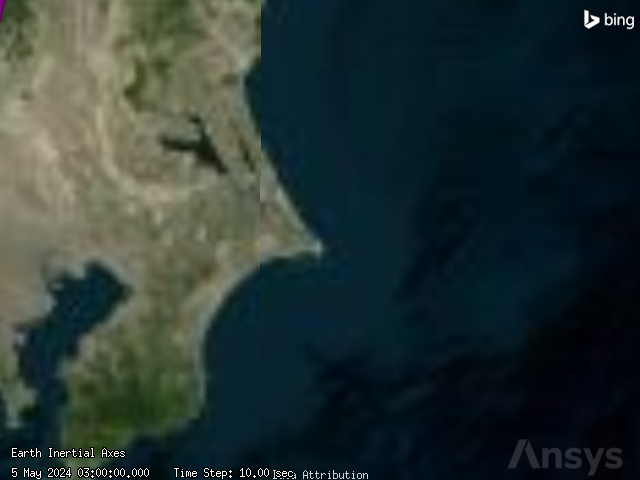

In [27]:
globe_widget.camera.position = [3555, 4084, 3861]
globe_widget.show()

## Calculate access

Next, get and compute the access between the sensor and the aircraft:

In [28]:
basic_access = antenna_sensor.get_access_to_object(aircraft)
basic_access.compute_access()

Generate an azimuth-elevation-range report to see the effect the constraints have on the accesses:

In [29]:
aer_df = (
    basic_access.data_providers.item("AER Data")
    .group.item("Default")
    .execute(scenario.start_time, scenario.stop_time, 60)
    .data_sets.to_pandas_dataframe()
)
aer_df

,access number,time,azimuth,elevation,range,azimuthrate,elevationrate,rangerate,path delay,from precision pass,to precision pass,from precision path,to precision path,strand name,local hour angle
0,1,5 May 2024 03:00:00.000000000,12.45404734722865,2.4262391541155717,142.19354620286657,7.41707399024173,8.578876466875577,-328.7986218202578,0.00047430661582175814,0.0,0.0,0.0,0.0,Place/RadarSite/Sensor/AntennaSensor to Aircra...,0.34378801541209814
1,2,5 May 2024 03:00:00.465588995,155.33552870842385,28.14590949842654,16.087906997688346,743.8957142523444,-461.9351423204619,241.15458349861123,5.366348141315932e-05,0.0,0.0,0.0,0.0,Place/RadarSite/Sensor/AntennaSensor to Aircra...,0.06527742842577614
2,1,5 May 2024 03:00:00.196816962,15.13110298811972,5.266574186930059,77.72474540872938,24.98925202844396,25.139771123401626,-326.49276232486045,0.00025926184376769536,0.0,0.0,0.0,0.0,Place/RadarSite/Sensor/AntennaSensor to Aircra...,0.2250116267314337
3,2,5 May 2024 03:00:00.673142400,183.62283078311037,5.031611184073533,80.8918491421213,23.054501011337923,-23.33292289256693,326.7468214886276,0.000269826164679971,0.0,0.0,0.0,0.0,Place/RadarSite/Sensor/AntennaSensor to Aircra...,359.9442713946181
4,1,5 May 2024 03:00:00.393633923,42.73106714577967,27.862184658609007,16.23764316519118,726.3999565882272,455.88376277654504,-243.07405443667042,5.416294750547454e-05,0.0,0.0,0.0,0.0,Place/RadarSite/Sensor/AntennaSensor to Aircra...,0.10769877459971705
5,2,5 May 2024 03:00:00.880695806,186.21207013940705,2.2570199217615854,148.92351178405576,6.760668503951863,-7.953516847366064,328.8833852117256,0.000496755364619799,0.0,0.0,0.0,0.0,Place/RadarSite/Sensor/AntennaSensor to Aircra...,359.82504611174136


Notice that the first access ends and the second access begins at an approximate elevation angle of $30$ degrees. There is a break in access when the elevation angle exceeds $30$ degrees due to the modeled cone of silence.

It is also possible to see this cone of silence on a plot of the aircraft's elevation when it is accessed by the sensor:

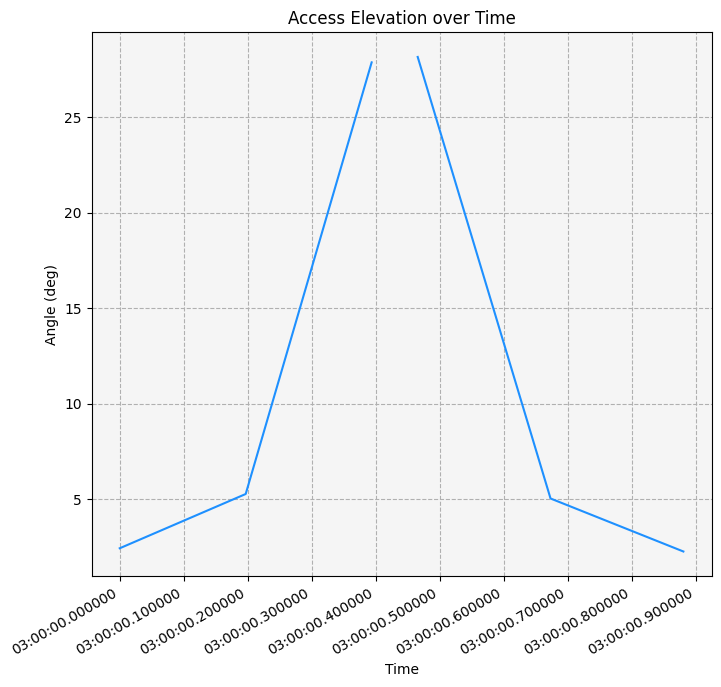

In [30]:
import matplotlib.dates as md
import matplotlib.pyplot as plt
import pandas as pd


# Convert columns to correct types
aer_df["time"] = pd.to_datetime(aer_df["time"])
aer_df["elevation"] = aer_df["elevation"].apply(pd.to_numeric)

# Create a plot
fig, ax = plt.subplots(figsize=(8, 8))

# Group by access number, then plot elevation
aer_df.groupby("access number").plot(x="time", y="elevation", ax=ax, color="dodgerblue")

# Set title and axes labels
ax.set_title("Access Elevation over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Angle (deg)")

# Configure style
ax.set_facecolor("whitesmoke")
ax.grid(visible=True, which="both", linestyle="--")

# Improve x-axis formatting
formatter = md.DateFormatter("%H:%M:%S.%f")
ax.xaxis.set_major_formatter(formatter)
# Set major and minor locators
xlocator_major = md.MicrosecondLocator(interval=100000)
ax.xaxis.set_major_locator(xlocator_major)

# Remove axis
ax.get_legend().remove()
plt.show()

## Insert an airport surveillance radar

Insert the airport surveillance radar on the sensor:

In [31]:
airport_radar = antenna_sensor.children.new(STKObjectType.RADAR, "Radar")

In this scenario, the radar is a monostatic radar with a search/track mode. A monostatic radar uses a common antenna for both transmitting and receiving. A search/track radar detects and tracks point targets. Both the monostatic radar type and the search/track mode are default when a radar is inserted, so there is no need to designate either.

## Define the waveform

Radar systems often use multiple pulse integration to increase the signal-to-noise ratio. The fixed pulse repetition frequency (PRF) is the number of pulses of a repeating signal in a specific time unit. After producing a brief transmission pulse, the transmitter is turned off in order for the receiver to hear the reflections of that signal off of targets. The default waveform for radars in STK uses a fixed PRF with a default value of $0.001$ MHz. In this case, the airport surveillance radar uses a fixed PRF of $1000$ Hz, so the defaults can be used directly.

## Define the pulse width

Pulse width is the width of the transmitted pulse (the uncompressed RF bandwidth can also be taken as the inverse of the pulse width). Set the pulse width to one microsecond:

In [32]:
from ansys.stk.core.stkobjects import RadarModelMonostatic


monostatic = RadarModelMonostatic(airport_radar.model_component_linking.component)
monostatic.mode_component_linking.component.waveform.pulse_definition.pulse_width = 1e-6

## Define the antenna model

The radar's antenna is modeled by the cosine squared aperture rectangular antenna pattern, with an antenna transmit frequency between $2.7$ and $2.9$ GHz. The antenna also has an X dimension beamwidth of $5^\circ$, a Y dimension beamwidth of $1.4^\circ$, a design frequency of $2.8$ GHz, a main-lobe gain of $34$ dB, and an efficiency of $55$%.

First, set the radar's antenna model to the cosine squared aperture rectangular antenna pattern:

In [33]:
from ansys.stk.core.stkobjects import AntennaModelApertureRectangularCosineSquared


antenna_control = airport_radar.model_component_linking.component.antenna_control
antenna_control.embedded_model_component_linking.set_component(
    "Cosine Squared Aperture Rectangular"
)
antenna_model = AntennaModelApertureRectangularCosineSquared(
    antenna_control.embedded_model_component_linking.component
)

Next, configure the antenna model to use beamwidth:

In [34]:
from ansys.stk.core.stkobjects import RectangularApertureInputType


antenna_model.input_type = RectangularApertureInputType.BEAMWIDTHS

Set the X beamwidth to $5^\circ$:

In [35]:
antenna_model.x_beamwidth = 5

Set the Y beamwidth to $1.4^\circ$

In [36]:
antenna_model.y_beamwidth = 1.4

Then, set the antenna's design frequency to $2.8$ GHz.

In [37]:
antenna_model.design_frequency = 2.8

Disable the automatic computation of main-lobe gain for the antenna. When the `compute_mainlobe_gain` property is set to `True`, the main-lobe gain is automatically calculated based on beamwidth or diameter, efficiency, and design frequency. In this case, disable the computation of main-lobe gain, and instead set the value to $34$ dB:

In [38]:
antenna_model.compute_mainlobe_gain = False
antenna_model.mainlobe_gain = 34

Finally, set the antenna's efficiency to $55$%:

In [39]:
antenna_model.efficiency = 55

## Define the radar transmitter

The transmitter has a frequency range of $2.7-2.9$ GHz, a peak power of $20$ kW, and uses linear polarization.

First, configure the transmitter to use frequency (instead of wavelength) as its frequency specification:

In [40]:
from ansys.stk.core.stkobjects import RadarFrequencySpecificationType


radar_transmitter = airport_radar.model_component_linking.component.transmitter
radar_transmitter.frequency_specification = RadarFrequencySpecificationType.FREQUENCY

Then, set the transmitter's frequency to $2.8$ GHz:

In [41]:
radar_transmitter.frequency = 2.8

Finally, set the transmitter's power to $20$ kW ($43.01$ dBW):

In [42]:
radar_transmitter.power = 43.01

Polarization is a property of an electromagnetic wave that describes the orientation of the electric field vector with reference to the antenna's orientation. An aircraft surveillance radar system can use linear or circular polarization. In this case, the transmitter uses linear polarization, in which the receiver is linearly polarized with the electrical field aligned with the reference axis.

Enable the use of polarization on the transmitter:

In [43]:
radar_transmitter.enable_polarization = True

Linear polarization is the default value for transmitters, so there is no need to change the polarization type.

## Configure the radar receiver

The radar's receiver uses linear polarization, and computes system noise temperature using the default values, and taking into account Sun and cosmic background noise.

First, enable polarization on the radar receiver:

In [44]:
radar_receiver = airport_radar.model_component_linking.component.receiver
radar_receiver.enable_polarization = True

Linear polarization is the default polarization type, so the default type can be used directly.

Next, add the receiver's system noise temperature. Compute system noise temperature using the default values, and take into account Sun and cosmic background noise.

Set the receiver's system noise temperature compute type to calculate:

In [45]:
from ansys.stk.core.stkobjects import NoiseTemperatureComputeType


radar_receiver.system_noise_temperature.compute_type = (
    NoiseTemperatureComputeType.CALCULATE
)

Then, use the receiver's system noise temperature's `antenna_noise_temperature` property to access an `AntennaNoiseTemperature` object, through which it is possible to set the antenna noise temperature parameters. Set the compute type to calculate and then enable the use of Sun and cosmic background in antenna noise temperature calculations:

In [46]:
radar_receiver.system_noise_temperature.antenna_noise_temperature.compute_type = (
    NoiseTemperatureComputeType.CALCULATE
)
radar_receiver.system_noise_temperature.antenna_noise_temperature.use_sun = True
radar_receiver.system_noise_temperature.antenna_noise_temperature.use_cosmic_background = True

## Determine the probability of detection

For this radar, the probability of detection (Pdet) is based on a value of $0.800000$ or higher, with $1$ being the highest value. Determine the Pdet for a large aircraft, a medium aircraft, a small aircraft, and a bird by changing the aircraft's constant RCS value to simulate different sized-targets.

Start by determining the Pdet of the large turboprop aircraft.

Compute access between the radar and the aircraft:

In [47]:
large_aircraft_access = airport_radar.get_access_to_object(aircraft)
large_aircraft_access.compute_access()

Next, generate a radar SearchTrack report using a step value of $30$ sec:

In [48]:
large_aircraft_df = (
    large_aircraft_access.data_providers.item("Radar SearchTrack")
    .execute(scenario.start_time, scenario.stop_time, 30)
    .data_sets.to_pandas_dataframe()
)

Select the report's `s/t pdet1` (the Pdet for a single pulse), `s/t integrated pdet` (the Pdet for multiple pulses), `s/t pulses integrated` (the number of pulses integrated), `s/t snr1` (the signal-to-noise ratio (SNR) for a single pulse), and `s/t integrated snr` (the SNR for multiple pulses):

In [49]:
large_aircraft_df[
    [
        "s/t pdet1",
        "s/t integrated pdet",
        "s/t snr1",
        "s/t integrated snr",
        "s/t pulses integrated",
    ]
]

,s/t pdet1,s/t integrated pdet,s/t snr1,s/t integrated snr,s/t pulses integrated
0,0.004241189154789869,0.8990454122417457,0.4039825109939072,16.085999751663856,37
1,1.0,1.0,38.487444062754676,38.487444062754676,1
2,1.0,1.0,38.333965316780535,38.333965316780535,1
3,0.0005349943277871887,0.2999687378212546,-5.246222130023764,16.024825853624314,134


As can be seen by the difference between the `s/t pdet1` and `s/t integrated pdet` columns, pulse integration improves the ability of the radar to detect targets by combining the returns from multiple pulses. Pulse integration also improves the signal-to-noise ratio.

## Simulate a medium-sized aircraft

To simulate a medium-sized aircraft, change the target aircraft's RCS to $10$ dBsm:

In [50]:
band1.compute_strategy.constant_value = 10

Then, compute access between the aircraft and the radar:

In [51]:
medium_aircraft_access = airport_radar.get_access_to_object(aircraft)
medium_aircraft_access.compute_access()

Generate a radar SearchTrack report using a step value of $30$ sec:

In [52]:
medium_aircraft_df = (
    medium_aircraft_access.data_providers.item("Radar SearchTrack")
    .execute(scenario.start_time, scenario.stop_time, 30)
    .data_sets.to_pandas_dataframe()
)

Select the `s/t pdet1`, `s/t integrated pdet`, `s/t pulses integrated`, `s/t snr1`, and `s/t integrated snr`:

In [53]:
medium_aircraft_df[
    [
        "s/t pdet1",
        "s/t integrated pdet",
        "s/t snr1",
        "s/t integrated snr",
        "s/t pulses integrated",
    ]
]

,s/t pdet1,s/t integrated pdet,s/t snr1,s/t integrated snr,s/t pulses integrated
0,0.00025371021992869145,0.07763118319057452,-8.596017489006092,16.012960938559388,289
1,1.0,1.0,29.48744406275468,29.48744406275468,1
2,1.0,1.0,29.33396531678053,29.33396531678053,1
3,0.0001332979757668818,0.0022131674685955697,-14.24622213002376,12.846477479734546,512


The radar's ability to track this aircraft has diminished due to the aircraft's smaller RCS.

## Simulate a small aircraft

To simulate a small aircraft, change the target aircraft's RCS to $0$ dBsm:

In [54]:
band1.compute_strategy.constant_value = 0

Then, compute access between the aircraft and the radar:

In [55]:
small_aircraft_access = airport_radar.get_access_to_object(aircraft)
small_aircraft_access.compute_access()

Generate a radar SearchTrack report using a step value of $30$ sec:

In [56]:
small_aircraft_df = (
    small_aircraft_access.data_providers.item("Radar SearchTrack")
    .execute(scenario.start_time, scenario.stop_time, 30)
    .data_sets.to_pandas_dataframe()
)

Select the `s/t pdet1`, `s/t integrated pdet`, `s/t pulses integrated`, `s/t snr1`, and `s/t integrated snr`:

In [57]:
small_aircraft_df[
    [
        "s/t pdet1",
        "s/t integrated pdet",
        "s/t snr1",
        "s/t integrated snr",
        "s/t pulses integrated",
    ]
]

,s/t pdet1,s/t integrated pdet,s/t snr1,s/t integrated snr,s/t pulses integrated
0,0.00011254140305492283,0.00034616354655054465,-18.596017489006094,8.496682120752215,512
1,1.0,1.0,19.487444062754676,19.487444062754676,1
2,1.0,1.0,19.33396531678053,19.33396531678053,1
3,0.00010345088906840799,0.00014192164338157505,-24.24622213002376,2.846477479734546,512


The radar's ability to track this aircraft has again diminished due to the aircraft's smaller RCS.

## Simulate a bird

To simulate a bird, change the target aircraft's RCS to $-20$ dBsm:

In [58]:
band1.compute_strategy.constant_value = -20

Then, compute access between the aircraft and the radar:

In [59]:
bird_aircraft_access = airport_radar.get_access_to_object(aircraft)
bird_aircraft_access.compute_access()

Generate a radar SearchTrack report using a step value of $30$ sec:

In [60]:
bird_aircraft_df = (
    bird_aircraft_access.data_providers.item("Radar SearchTrack")
    .execute(scenario.start_time, scenario.stop_time, 30)
    .data_sets.to_pandas_dataframe()
)

Select the `s/t pdet1`, `s/t integrated pdet`, `s/t pulses integrated`, `s/t snr1`, and `s/t integrated snr`:

In [61]:
bird_aircraft_df[
    [
        "s/t pdet1",
        "s/t integrated pdet",
        "s/t snr1",
        "s/t integrated snr",
        "s/t pulses integrated",
    ]
]

,s/t pdet1,s/t integrated pdet,s/t snr1,s/t integrated snr,s/t pulses integrated
0,9.998618444776282e-05,0.00010148169909176745,-38.596017489006094,-11.503317879247785,512
1,0.0028605647015461574,0.8289110078005205,-0.5125559372453223,16.019569200508116,45
2,0.0026825084239399796,0.8206050695303343,-0.6660346832194677,16.054943896137708,47
3,9.999623842592416e-05,0.00010050601836099273,-44.24622213002376,-17.153522520265454,512


The Pdet is very low for an object with this RCS. To track objects like birds, the radar system would need a different frequency or higher power.

## Load an external Aspect Dependent RCS file

Using an Aspect Dependent RCS file built for a specific target aircraft generates much more realistic data.

To use an external file, first set the target aircraft's RCS to use an external file in computations:

In [62]:
band1.set_compute_strategy("External File")

Then, upload the `X-47B_Notional_Sample.rcs` file, which is included with the STK install, by using the band's `compute_strategy` property, which now holds a `RadarCrossSectionComputeStrategyExternalFile` object:

In [63]:
import pathlib


install_dir = root.execute_command("GetDirectory / STKHome")[0]
band1.compute_strategy.filename = str(
    pathlib.Path(install_dir)
    / "Data"
    / "Resources"
    / "stktraining"
    / "samples"
    / "SeaRangeResources"
    / "X-47B"
    / "X-47B_Notional_Sample.rcs"
)

It is now possible to see the aircraft's aspect dependent RCS pattern in the 3D graphics window:

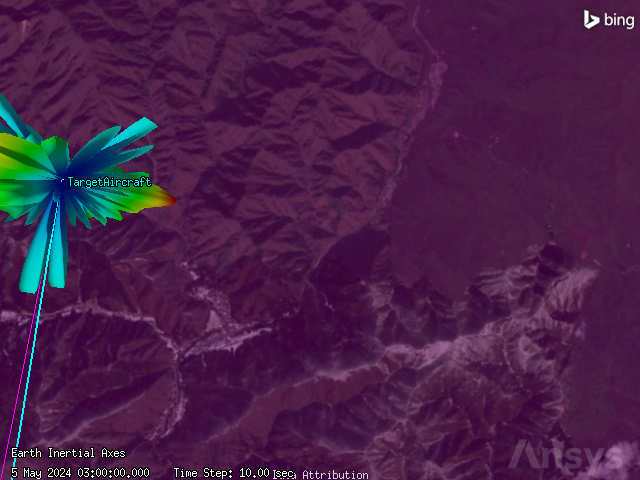

In [64]:
globe_widget.camera.position = [3435.3329, 3789.8112, 3815.5677]
globe_widget.show()

Recompute the access between the aircraft and the radar:

In [65]:
aspect_dep_aircraft_access = airport_radar.get_access_to_object(aircraft)
aspect_dep_aircraft_access.compute_access()

Generate a radar SearchTrack report using a step value of $30$ sec:

In [66]:
aspect_dep_df = (
    aspect_dep_aircraft_access.data_providers.item("Radar SearchTrack")
    .execute(scenario.start_time, scenario.stop_time, 30)
    .data_sets.to_pandas_dataframe()
)

Select the `s/t pdet1`, `s/t integrated pdet`, `s/t pulses integrated`, `s/t snr1`, and `s/t integrated snr`:

In [67]:
aspect_dep_df[
    [
        "s/t pdet1",
        "s/t integrated pdet",
        "s/t snr1",
        "s/t integrated snr",
        "s/t pulses integrated",
    ]
]

,s/t pdet1,s/t integrated pdet,s/t snr1,s/t integrated snr,s/t pulses integrated
0,0.00010357772989095509,0.0001439764356074659,-24.088820853084524,3.003878756673781,512
1,0.7754405309015666,0.9999987492289983,10.868408484863252,16.889008398142874,4
2,0.23677011455720495,0.9997005710099416,7.734541751840621,16.18552215198319,7
3,0.00010132858779850437,0.0001147151699025594,-28.402239189069576,-1.3095395793112694,512


Depending on the reflection from the aircraft back to the radar, it is possible for there to be fluctuation in the values. This is noticeable in the S/T Pulses Integrated column.

## Graph the RCS

Use the Radar RCS report to get information about how the RCS changes over time:

In [68]:
rcs_df = (
    aspect_dep_aircraft_access.data_providers.item("Radar RCS")
    .execute(scenario.start_time, scenario.stop_time, 1)
    .data_sets.to_pandas_dataframe()
)

In [69]:
rcs_df["incident el bf"]

0     3.709178
1    28.240029
2    28.006714
3     3.161044
4         None
5      3.10671
Name: incident el bf, dtype: object

Visualize changes to the RCS and the elevation:

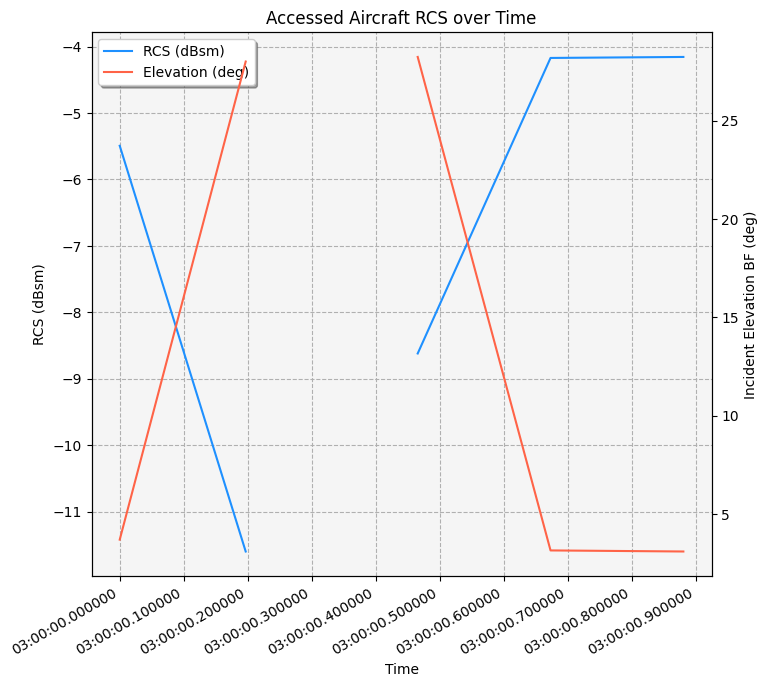

In [70]:
import matplotlib.dates as md
import matplotlib.pyplot as plt
import pandas as pd


# Convert columns to correct types
rcs_df["time"] = pd.to_datetime(aer_df["time"])
cols = ["rcs", "incident el bf"]
rcs_df[cols] = rcs_df[cols].apply(pd.to_numeric)

# Create a plot
fig, ax = plt.subplots(figsize=(8, 8))
# Duplicate axis
ax2 = ax.twinx()

# Group by access number, then plot rcs and elevation
rcs_df.groupby("access number").plot(
    x="time", y="rcs", ax=ax, color="dodgerblue", label="RCS (dBsm)"
)
rcs_df.groupby("access number").plot(
    x="time", y="incident el bf", ax=ax2, color="tomato", label="Elevation (deg)"
)

# Set title and axes labels
ax.set_title("Accessed Aircraft RCS over Time")
ax.set_xlabel("Time")
ax.set_ylabel("RCS (dBsm)")
ax2.set_ylabel("Incident Elevation BF (deg)")

# Configure style
ax.set_facecolor("whitesmoke")
ax.grid(visible=True, which="both", linestyle="--")

# Combine legends
lines = [ax.get_lines()[0], ax2.get_lines()[0]]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, shadow=True)
ax2.get_legend().remove()

# Improve x-axis formatting
formatter = md.DateFormatter("%H:%M:%S.%f")
ax.xaxis.set_major_formatter(formatter)
# Set major and minor locators
xlocator_major = md.MicrosecondLocator(interval=100000)
ax.xaxis.set_major_locator(xlocator_major)

plt.show()

As seen previously, there is a cone of silence in the middle of the graph, corresponding to when the elevation angle is over $30^\circ$.